In [19]:
import numpy as np
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [2]:
from keras.applications import VGG16

In [20]:
def get_vggCountNet(count_max=16):
    base_model = VGG16(weights='imagenet', include_top=True)
    fc2 = base_model.get_layer(name='fc2').output
    count = Dense(count_max, activation='softmax', name='predictions')(fc2)
    model = Model(inputs=base_model.input, outputs=count)
    for layer in base_model.layers:
        layer.trainable = False
    return model

In [4]:
def get_block_loc(shape, x, y, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise Exception("Can't find block...??")

In [5]:
class CountIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param x_mean: Mean per channel for input normalization
    :param x_std: Standard deviation per channel for input normalization
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 x_mean, x_std,
                 count_max=16,
                 n_samples_per_image=160,
                 target_size=(224, 224),
                 batch_size=8, shuffle=True, seed=42):
        
        self.image_ids = image_ids
        self.count_max = count_max
        self.x_mean = x_mean
        self.x_std = x_std
        self.root_dir = root_dir
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(CountIterator, self).__init__(self.n_indices, batch_size, shuffle, seed)
        
    def __normalize_input__(self, batch_x):
        return (batch_x/255 - self.x_mean)/self.x_std

    def __sample__(self, shape, dots, image_id):
        pbackground = 0.2
        threshold_masked = 0.3 # if more than 30% of the patch is masked, reject it
        
        adots = []
        for _, ds in dots.items():
            for x, y in ds:
                if 0 <= x < shape[1] and 0 <= y < shape[0]:
                    adots.append((x, y))
                    
        bg_or_dots = np.random.choice(2, size=(1, ), p=[pbackground, 1-pbackground])
        
        while 1:
            if bg_or_dots[0] == 0 or len(adots) == 0:
                x, y = self.sample_bg(shape, image_id)
            else:
                x, y = self.sample_dot(shape, adots, image_id)

            try:
                bid, x, y = get_block_loc(shape, x, y)
            except:
                continue
            uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))/255
            img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
            masked_pixels = np.count_nonzero(img_patch == 0)
            total_pixels = img_patch.shape[0] * img_patch.shape[1]
            if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                continue
            if masked_pixels/total_pixels < threshold_masked:
                dmap = np.load(os.path.join(self.root_dir, "TrainDensity", uid + ".npz"))['dmap']
                dmap_path = dmap[y:y+self.target_size[0], x:x+self.target_size[1],:]
                count = np.floor(np.sum(dmap_path))
                if count >= self.count_max:
                    continue
                return img_patch, count
        
    def sample_bg(self, shape, image_id):
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, adots, image_id):
        half_size = 36
        
        randi = np.random.choice(len(adots), size=(1,))[0]
        rand_dot = adots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x >= max_x:
            max_x, min_x = min_x, max_x
        if min_y >= max_y:
            max_y, min_y = min_y, max_y 
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        batch_x = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size, self.count_max), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.__sample__(shape, dots, image_id)
            batch_x[i,:,:,:] = x
            batch_y[i, :] = to_categorical(y, num_classes=self.count_max)     

        return self.__normalize_input__(batch_x), batch_y

In [6]:
with open("../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(s[:-4]) for s in train_ids]

with open("../data/sealion/dots_ok.json", "r") as jfile:
    dots_ok = json.load(jfile)
dots_ok = [int(s[:-4]) for s in dots_ok]

with open("../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(s[:-4]) for s in val_ids]

train_ids = list(set(train_ids).intersection(set(dots_ok)))
val_ids = list(set(val_ids).intersection(set(dots_ok)))

In [7]:
mean_bgr = np.load("../data/sealion/mean_bgr.npy")
std_bgr = np.load("../data/sealion/std_bgr.npy")
trainPatchesGenerator = CountIterator("/home/lowik/sealion/data/sealion/", train_ids, mean_bgr, std_bgr, 16)
valPatchesGenerator = CountIterator("/home/lowik/sealion/data/sealion/", val_ids, mean_bgr, std_bgr, 16)

In [8]:
for batch_x, batch_y in trainPatchesGenerator:
    break

9


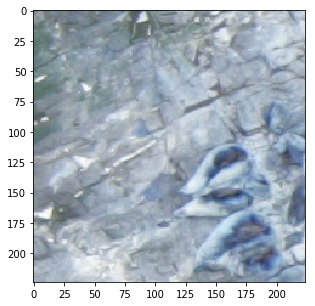

In [9]:
s = 6
plt.figure(figsize=(5, 5))
plt.imshow( ((batch_x[s,:,:,:] * std_bgr) + mean_bgr) * 255)
print(np.argmax(batch_y, axis=-1)[s])

In [26]:
countNet = get_vggCountNet(16)
countNet.compile(optimizer='rmsprop', loss=categorical_crossentropy)

In [27]:
h = countNet.fit_generator(trainPatchesGenerator, 100, epochs=2, verbose=1, callbacks=None, validation_data=valPatchesGenerator, validation_steps=20, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/2
100/100 [==============================] - 628s - loss: 2.3007 - val_loss: 2.0617
Epoch 2/2
100/100 [==============================] - 569s - loss: 2.0281 - val_loss: 1.6587


In [28]:
countNet.save("../data/countNet.h5")

In [29]:
for layer in countNet.layers:
    layer.trainable = True

In [30]:
countNet.compile(optimizer=SGD(lr=0.00001, momentum=0.9, nesterov=True), loss='categorical_crossentropy')

In [31]:
h2 = countNet.fit_generator(trainPatchesGenerator, 100, epochs=2, verbose=1, callbacks=None, validation_data=valPatchesGenerator, validation_steps=20, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/2
100/100 [==============================] - 1349s - loss: 1.6154 - val_loss: 1.6861
Epoch 2/2
 61/100 [=================>............] - ETA: 506s - loss: 1.6146

KeyboardInterrupt: 